In [0]:
import urllib.request
import os
import numpy as np
from sklearn.model_selection import train_test_split
import time
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [30]:
data_url = ["""https://raw.githubusercontent.com/UniversalDependencies/UD_Akkadian-PISANDUB/master/akk_pisandub-ud-test.conllu""", """https://raw.githubusercontent.com/UniversalDependencies/UD_Swedish-LinES/master/sv_lines-ud-test.conllu""",
            """https://raw.githubusercontent.com/UniversalDependencies/UD_French-GSD/master/fr_gsd-ud-dev.conllu""", """https://raw.githubusercontent.com/UniversalDependencies/UD_Hungarian-Szeged/master/hu_szeged-ud-train.conllu""", 
            """https://raw.githubusercontent.com/UniversalDependencies/UD_Korean-GSD/master/ko_gsd-ud-train.conllu"""]

sources = []
for data in data_url:
  sources.append(data.split("/")[-1])

for source in sources:
  for data in data_url:
    urllib.request.urlretrieve(data, source)
  
!ls

akk_pisandub-ud-test.conllu  hu_szeged-ud-train.conllu	sv_lines-ud-test.conllu
fr_gsd-ud-dev.conllu	     ko_gsd-ud-train.conllu


In [0]:
X = []
y = []

def load_conllu(file):
    with open(file, "r") as infile:
        sents = infile.read().split("\n\n")
        if sents[-1] == "":
            sents = sents[:-1]
        for sent in sents:
            words, tags = [], []
            lines = sent.split("\n")
            for line in lines:
                if line.startswith("#"):
                    continue
                line = line.strip().split("\t")
                if len(line) != 10:
                    raise TabError("Tried to read .txt file, but did not find ten columns.")
                else:
                    words.append(line[1])
                    tags.append(line[3])
            X.append(words)
            y.append(tags)

    return X, y


In [0]:
def tag_mean_accuracy(y, y_hat):
  accuracy = list()
  for u, v in zip(y, y_hat):
    accuracy.append(np.sum([e1==e2 for e1, e2 in zip(u, v)])/len(u))
  return np.mean(accuracy), np.std(accuracy)

In [33]:
load_conllu('sv_lines-ud-test.conllu')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

print("The training set includes %i sentences" % len(X_train))
print("The test set includes %i sentences" % len(X_test))

The training set includes 3960 sentences
The test set includes 440 sentences


In [34]:
# Preparing using all the data since there is no 'unknown' symbol implemented yet 
word2idx = {'<PAD>': 0, '<UNK>': 1}
tag2idx = dict()
def zipper(xx, yy):
  for sentence, tags in zip(xx, yy):
    for word in sentence:
      word = word.lower()
      if word not in word2idx:    # The 'in' operator is fast for dictionaries
        word2idx[word] = len(word2idx)
    for tag in tags:
      if tag not in tag2idx:
        tag2idx[tag] = len(tag2idx)
  tag2idx['<PAD>'] = len(tag2idx)

zipper(X_train, y_train)

print(word2idx)
print(tag2idx)

# Creates lists for converting indeces to tags or words
idx2word = [None]*len(word2idx)
for word, idx in word2idx.items():
  idx2word[idx] = word
idx2tag = [None]*len(tag2idx)
for tag, idx in tag2idx.items():
  idx2tag[idx] = tag

print(idx2word[:10])
print(idx2tag[:10])

{'<PAD>': 0, '<UNK>': 1, '최종적으로': 2, '8': 3, '산악사단으로': 4, '개편된': 5, '것은': 6, '1945년': 7, '2월이었다': 8, '.': 9, '구름의': 10, '윗부분은': 11, '빙정': 12, ',': 13, '아랫부분은': 14, '물방울로': 15, '이루어져': 16, '있다': 17, '이는': 18, '턱관절장애': 19, '치료에': 20, '가장': 21, '많이': 22, '사용되고': 23, '있는': 24, '치료법으로': 25, '턱관절에': 26, '부담을': 27, '덜기': 28, '때문에': 29, '손상받은': 30, '부위가': 31, '치유되는': 32, '것을': 33, '촉진한다': 34, '초기': 35, '포르투갈': 36, '선교사들의': 37, '노력을': 38, '바탕으로': 39, '1651년': 40, '알렉상드르': 41, '드': 42, '로드가': 43, '딕시오나리움': 44, '아나미티쿰': 45, '루시타눔': 46, '엣': 47, '라티눔': 48, '(': 49, '안남어-포르투갈어-라틴어': 50, '사전': 51, ')': 52, '로': 53, '17세기': 54, '포르투갈어': 55, '표기법에': 56, '기초한': 57, '현대': 58, '베트남어': 59, '표기법을': 60, '소개했다': 61, '양념된': 62, '닭고기를': 63, '바삭하게': 64, '튀겨서': 65, '정말': 66, '맛있어요': 67, '하지만': 68, '프레디는': 69, '이': 70, '말을': 71, '무시했다': 72, '원래': 73, '코레일유통이': 74, '분사되기': 75, '전에는': 76, '역사내': 77, '매점': 78, '등도': 79, '운영하였다': 80, '제주산': 81, '돼지고기인데': 82, '청결도': 83, '기본': 84, '!': 85, '예멘에서': 86, '33년간': 87, '장기':

In [35]:
def pad_data(sentences, labels):
  assert len(sentences)==len(labels)
  assert np.all([len(sentence)==len(tags) for sentence, tags in zip(sentences, labels)])
  max_len = np.max([len(sentence) for sentence in sentences]) # Find out how much to pad
  padded_sentences  = list()
  padded_labels  = list()
  for sentence, tags in zip(sentences, labels):               # Loop over the data
    padded_sentence = [word.lower() if word.lower() in word2idx else '<UNK>' for word in sentence]  # Sentence, uses the <UNK> symbol for unknown words
    padded_tags = [tag for tag in tags]                       # Tags
    while len(padded_sentence) < max_len:                     # Adds padding to the sequences 
      padded_sentence.append('<PAD>')
      padded_tags.append('<PAD>')
    padded_sentences.append(padded_sentence)                  # Append the processed sample to the output
    padded_labels.append(padded_tags)
  return padded_sentences, padded_labels

def encode_data(padded_sentences, padded_labels):
  encoded_sentences = list()
  for padded_sentence in padded_sentences:
    encoded_sentences.append([word2idx[word] for word in padded_sentence])
  encoded_labels = list()
  for padded_tags in padded_labels:
    encoded_labels.append([tag2idx[tag] for tag in padded_tags])
  return torch.LongTensor(encoded_sentences), torch.LongTensor(encoded_labels)

a, b = pad_data(X_train[:], y_train[:])
print(a)
print(b)
c, d = encode_data(a, b)
print(c)
print(d)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [0]:
def split_data(sentences, labels, batch_size=500):
  """Splits the data into (almost) even batches."""
  assert len(sentences) == len(labels)
  n_folds = len(sentences)//batch_size
  ret = list()
  for i, x, t in zip(range(len(sentences)), sentences, labels):
    if len(ret) < n_folds:
      ret.append([[x], [t]])
    else:
      ret[i % n_folds][0].append(x)
      ret[i % n_folds][1].append(t)
  assert len(sentences) == np.sum([len(fold[0]) for fold in ret])
  return ret

X_train_folds = list()
y_train_folds = list()
for fold in split_data(X_train, y_train, batch_size=2000):
  x, t = encode_data(*pad_data(fold[0], fold[1]))
  X_train_folds.append(x)
  y_train_folds.append(t)

In [37]:
class LSTMTagger(nn.Module):
  def __init__(self, word_embedding_dim, lstm_hidden_dim, vocabulary_size, tagset_size):
    """An LSTM based tagger
    
    word_embedding_dim
      The dimensionality of the word embedding
    lstm_hidden_dim
      The dimensionality of the ...
    vocabulary_size
      The size of the vocabulary (i.e. the number of unique words in the word embedding)
    tagset_size
    """
    super(LSTMTagger, self).__init__()                                  # We need to initialise the class we are inheriting from
    self.lstm_hidden_dim = lstm_hidden_dim                             # This simply stores the parameter
    self.vocabulary_size = vocabulary_size
    self.tagset_size = tagset_size
    self._word_embeddings = nn.Embedding(num_embeddings=vocabulary_size,     # Creates the vector space for the input words
                                         embedding_dim=word_embedding_dim, 
                                         padding_idx=word2idx['<PAD>'])
    self._lstm = nn.LSTM(input_size=word_embedding_dim,                 # The LSTM takes an embedded sentence as input, and outputs 
                         hidden_size=lstm_hidden_dim,                   # vectors with dimensionality lstm_hidden_dim.
                         batch_first=True)
    
    self._hidden2tags = nn.Linear(lstm_hidden_dim, tagset_size)         # The linear layer maps from the RNN output space to tag space
                                      
  def forward(self, padded_sentences):
    """The forward pass through the network"""

    batch_size, max_sentence_length = padded_sentences.size()

    sentence_lengths = list()
    for i in range(batch_size):
      for j in range(max_sentence_length, 1, -1):
        if padded_sentences[i, j-1] != word2idx['<PAD>']:
          sentence_lengths.append(j)
          break
    sentence_lengths = torch.LongTensor(sentence_lengths)
    embedded_sentences = self._word_embeddings(padded_sentences)                            # Sentences encoded as integers are mapped to vectors    

    X = nn.utils.rnn.pack_padded_sequence(embedded_sentences, sentence_lengths,
                                          batch_first=True, enforce_sorted = False)
    lstm_out, _ = self._lstm(X)
    X, _ = nn.utils.rnn.pad_packed_sequence(X, batch_first=True)

    X = X.contiguous()
    X = X.view(-1, X.shape[2])

    tag_space = self._hidden2tags(X)     
    # The output from the LSTM layer is flattened and passed to the fully 
                                                                        # connected layer.
    tag_scores = F.log_softmax(tag_space, dim=1)                        # Softmax is applied to normalise the outputs

    return tag_scores.view(batch_size, max_sentence_length, self.tagset_size)

# These will usually be 32 or 64 dimensional.
WORD_EMBEDDING_DIM = 32
HIDDEN_DIM = 32

# This instantiates the network
model = LSTMTagger(word_embedding_dim=WORD_EMBEDDING_DIM, 
                   lstm_hidden_dim=HIDDEN_DIM,
                   vocabulary_size=len(word2idx),                            # The vocabulary incudes both the 'padding' and 'unknown' symbols
                   tagset_size=len(tag2idx)-1)                          # We have no interest in the network outputing the padding symbol
print(model)

LSTMTagger(
  (_word_embeddings): Embedding(25409, 32, padding_idx=0)
  (_lstm): LSTM(32, 32, batch_first=True)
  (_hidden2tags): Linear(in_features=32, out_features=16, bias=True)
)


In [0]:
class GRUTagger(nn.Module):
  def __init__(self, word_embedding_dim, gru_hidden_dim, vocabulary_size, tagset_size):
    super(EncoderTextGru, self).__init__()
    self.word_embedding_dim = nn.Embedding(num_embeddings=vocabulary_size,     # Creates the vector space for the input words
                                         embedding_dim=word_embedding_dim, 
                                         padding_idx=word2idx['<PAD>'])
    self.gru_hidden_dim = gru_hidden_dim
    self.vocabulary_size = vocabulary_size
    self.tagset_size = tagset_size
    self._gru = nn.GRU(input_size=word_embedding_dim, hidden_size=gru_hidden_dim,
                      batch_first=True, bidirectional=True)
    
    def forward(self, padded_sentences, hidden):
        embedded = self.embedding(padded_sentences).view(1, 1, -1)
        output = embedded
        #output, hidden = self._gru(output, hidden)

        bi_output, bi_hidden = self._gru(output,hidden)
        reverse_output, reverse_hidden = self.reverse_gru(output,hidden)

        #return output, hidden
        return torch.cat((bi_output,reverse_output)), torch.cat((bi_hidden, reverse_hidden))

In [39]:
# We choose a loss function that fits our choice of output layer and data. The
# loss function is set to ignore the padding index in the output.
loss_function = nn.NLLLoss(ignore_index=tag2idx['<PAD>'])

# We give the optimiser the parameters to work with and a learning rate
# optimizer = optim.SGD(model.parameters(), lr=0.8)
optimizer = optim.Adam(model.parameters(), lr=0.05)

loss_for_plotting = list()
start_t = time.time()
for epoch in range(2):
  for inputs, targets in zip(X_train_folds, y_train_folds): # Now for looping over the training data
    model.zero_grad()                                       # Reset gradients
    tag_scores = model(inputs)                              # Forward pass
    tag_scores = tag_scores.view(-1, model.tagset_size)     # Resize to get tag probabilities along a separate dimension
                                                            # but flatten all the different sentences
    targets = targets.view(-1)                              # Flatten y
    loss = loss_function(tag_scores, targets)               # Get loss
    loss.backward()                                         # Backpropagate the error
    optimizer.step()                                        # Run the optimizer to change the weights w.r.t the loss

    loss_for_plotting.append(loss.item())                   # Save the loss for plotting
  print("Epoch %i: loss=%.3f, time=%.1fs" % (epoch, loss, time.time()-start_t))

Epoch 0: loss=2.945, time=4.7s
Epoch 1: loss=2.599, time=9.2s


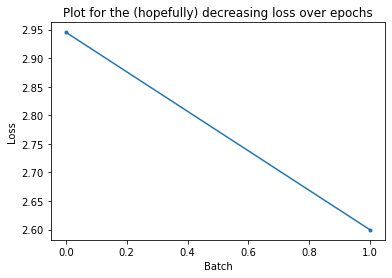

In [40]:
import matplotlib.pyplot as plt

plt.figure()
plt.title("Plot for the (hopefully) decreasing loss over epochs")
plt.plot(loss_for_plotting, '.-')
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.show()

In [41]:
with torch.no_grad():
  inputs, _ = encode_data(*pad_data(X_test, y_test))                # The test data must be in the allowed input format
  tag_scores = model(inputs)                                        # Runs the test data through the model
  tag_idx = np.asarray(np.argmax(tag_scores.numpy(), axis=2), dtype=np.int) # Get the most likely tag indeces
  y_hat = list()                                                    # The model predicts indeces but we want tags
  for i in range(tag_scores.shape[0]):                              # Loop over test samples
    padding_mask = inputs[i, :] != word2idx['<PAD>']                # Prepare to mask out padding
    y_hat.append([idx2tag[e] for e in tag_idx[i, padding_mask]])    # Remove padding and transform to tags

accuracy, sigma = tag_mean_accuracy(y_test, y_hat)
print("Mean accuracy: %.1f%% [std %.1f%%]" % (100*accuracy, 100*sigma))

Mean accuracy: 26.6% [std 14.9%]


I was able to upload the files and run the model on the files. In order for the model to run on the files, they will need to be put in one by one. With Korean, the model achieved an accuracy of 24%. With Swedish, an accuracy of 93.7%. 

I realized that the idx2word and idx2tag lists were still filled with Korean words and I do not know why. From this point on, the accuracy of the model decreased dramatically to around 20% for most languages. I do not know why the lists didn't reset everytime I put in a new file. 

I was able to add a GRU. In order to make it bidirectional, I simply changed the bidirectional parameter to True. 

I was unsure how to refactor everything into a class. I originally tried attempting to accomplish this, but I ran into the issue of splitting the data into the test and train lists from a class.

The hardest part was starting this assignment by figuring out how to import the conllu files from the internet into Colab. I tried to figure it out for about 3 hours. Once that was done, I was able to use the code provided in the assignment to run and train the model. Another hard part of the assignment was figuring out how to exactly import and run the GRU. I read the manual from Pytorch and just replaced the pregiven parameters with the ones provideded in the LSTM. I am unsure if this is correct to do. I also am unsure if I need to have a forward function for the GRU. The whole assignment was difficult overall.